In [27]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [29]:
Xy_numu = np.load("Xy_numu_97.npz")
Xy_nue = np.load("Xy_nue_97.npz")

In [30]:
X_numu = Xy_numu["x"]
y_numu = Xy_numu["y"]

In [31]:
X_nue = Xy_nue["x"]
y_nue = Xy_nue["y"]

np.save("X_numu.npy",X_numu)
np.save("Y_numu.npy",Y_numu)
np.save("X_nue.npy",X_nue)
np.save("Y_nue.npy",Y_nue)

In [32]:
print('X_numu: ', X_numu.shape, 'X_nue: ', X_nue.shape, 'y_numu: ', y_numu.shape, 'y_nue: ', y_nue.shape)

('X_numu: ', (1494, 75, 16, 15, 18), 'X_nue: ', (1071, 75, 16, 15, 18), 'y_numu: ', (1494,), 'y_nue: ', (1071,))


In [33]:
X = np.vstack((X_numu, X_nue))

In [34]:
y = np.hstack((y_numu, y_nue))

In [44]:
X = np.sum(X, axis=1)

In [8]:
print(X.shape, y.shape)

((2555, 75, 16, 15, 18), (2555,))


In [35]:
import keras

In [10]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [11]:
get_available_gpus()

[u'/gpu:0']

In [12]:
keras.backend.image_data_format()

'channels_first'

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [14]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

In [15]:
from history_plot import history_plot, history_plot_cv

In [16]:
print("X size: %d, y size: %d" %(X.shape[0], y.shape[0]) )

X size: 2555, y size: 2555


In [36]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [37]:
print(X_train.shape, y_train.shape, indx_train.shape)
print(X_test.shape, y_test.shape, indx_test.shape)

((2052, 75, 16, 15, 18), (2052,), (2052,))
((513, 75, 16, 15, 18), (513,), (513,))


In [21]:
# Check that Stratification worked
print(y[y==0].shape, y_train[y_train==0].shape, y_test[y_test==0].shape)
print(y[y==1].shape, y_train[y_train==1].shape, y_test[y_test==1].shape)

((1071,), (857,), (214,))
((1494,), (1195,), (299,))


In [21]:
img_channel = X_train.shape[1]
conv_dim_1 = X_train.shape[2]
conv_dim_2 = X_train.shape[3]
conv_dim_3 = X_train.shape[4]
inputshape = (img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(inputshape)

IndexError: tuple index out of range

In [23]:
img_channel = 1
conv_dim_1 = X_train.shape[1]
conv_dim_2 = X_train.shape[2]
conv_dim_3 = X_train.shape[3]
X_train_notime = X_train.reshape(X_train.shape[0], img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
inputshape = (img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(X_train_notime.shape)
print(inputshape)

(2052, 1, 16, 15, 18)
(1, 16, 15, 18)


##### Setup Model Callbacks

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)
reduce_lr_noval = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

#### Create Deep Network Model

In [23]:
def cnn_model(num_classes, optimizer):
    model = Sequential()
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', input_shape=inputshape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [25]:
from keras.backend import clear_session

def cross_validation_score(K, N, X_train, y_train, f_model, f_args, fit_args):
    """"""
    iteration_tr_score = list()
    iteration_val_score = list()
    histories_cnn = list()
    
    def iteration_metrics(scores):
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return mean_score, min_score, max_score
    
    for iteration in range(N):
        tr_accuracy_scores = list()
        val_accuracy_scores=list()
        
        skf = StratifiedKFold(n_splits=K, random_state=iteration)
        
        for i, (train_index, validation_index) in enumerate(skf.split(X_train, y_train)):
            print("[Iteration %d/%d] Test nr.: %d/%d" % (iteration+1, N, i+1, K))
            
            Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
            ytrain, yvalidation = y_train[train_index], y_train[validation_index]

            model = f_model(**f_args)
            
            if iteration == 0 and i == 0:
                model.summary()
            
            Ytrain = to_categorical(ytrain)
            Yvalidation = to_categorical(yvalidation)
            history = model.fit(Xtrain, Ytrain, validation_data = (Xvalidation, Yvalidation), 
                                shuffle=False, **fit_args) 
                        
            histories_cnn.append(history)
            training_acc = history.history['acc'][-1]
            validation_acc = history.history['val_acc'][-1]
            
            print("\nTraining acc: %f, Validation acc: %f\n" %(training_acc,validation_acc))
            tr_accuracy_scores.append(training_acc)
            val_accuracy_scores.append(validation_acc)
            
        iteration_tr_score.append(iteration_metrics(tr_accuracy_scores))
        iteration_val_score.append(iteration_metrics(val_accuracy_scores))
        
    clear_session()
        
    print("Training metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_tr_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))
    
    print("Validation metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_val_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))

    return histories_cnn

In [23]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

In [29]:
import history_plot
reload(history_plot)
len(history_info_50)

6

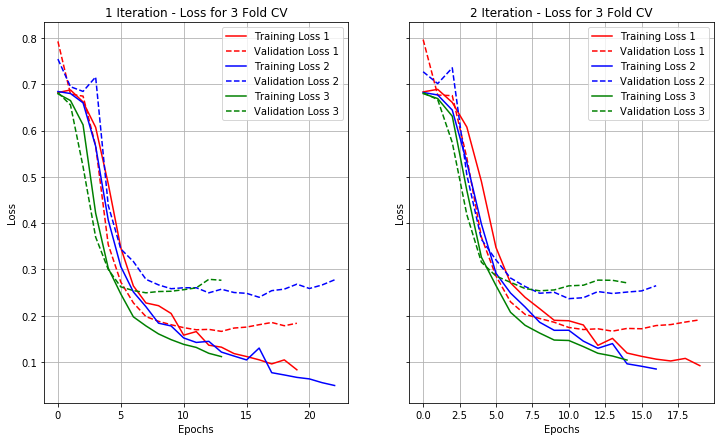

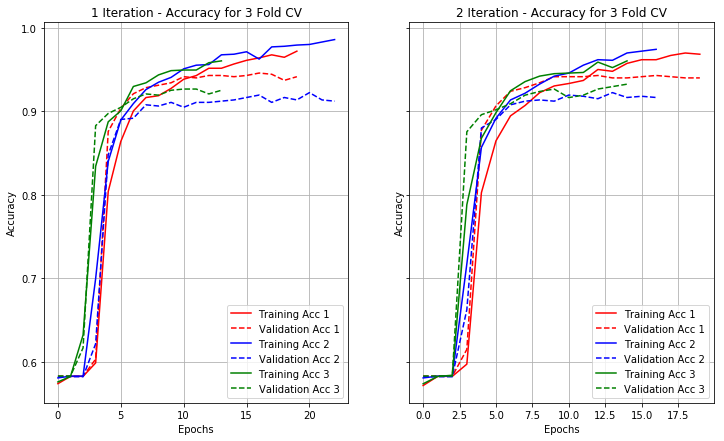

In [25]:
 %matplotlib inline
history_plot.history_plot_cv(history_info,"", "show", K=n_splits, N=n_iterations)

In [27]:
Ytrain = to_categorical(y_train)
batch = 64
epochs = 30
print("Train model on the whole train dataset - no validation")
model=cnn_model(num_classes= 2, optimizer=keras.optimizers.Adadelta())
repl_history = model.fit(X_train, Ytrain, batch_size=batch, epochs=epochs, callbacks=[early_stop_noval])  # replicate conf.


Train model on the whole train dataset - no validation
Epoch 1/30
2052/2052 [==============================] - 6s - loss: 0.6731 - acc: 0.5824     
Epoch 2/30
2052/2052 [==============================] - 6s - loss: 0.5629 - acc: 0.6613     
Epoch 3/30
2052/2052 [==============================] - 6s - loss: 0.3683 - acc: 0.8762     
Epoch 4/30
2052/2052 [==============================] - 5s - loss: 0.2651 - acc: 0.9020     
Epoch 5/30
2052/2052 [==============================] - 6s - loss: 0.2291 - acc: 0.9162     
Epoch 6/30
2052/2052 [==============================] - 6s - loss: 0.1792 - acc: 0.9313     
Epoch 7/30
2052/2052 [==============================] - 5s - loss: 0.1652 - acc: 0.9401     
Epoch 8/30
2052/2052 [==============================] - 6s - loss: 0.1554 - acc: 0.9493     
Epoch 9/30
2052/2052 [==============================] - 5s - loss: 0.1340 - acc: 0.9522     
Epoch 10/30
2052/2052 [==============================] - 5s - loss: 0.1206 - acc: 0.9581     
Epoch 11/30
20

In [29]:
print("Use model to make prediction on test data")
predictions = model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.93372319688109162)


In [30]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = indx_test[np.where(cls_predictions!=y_test)]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,y_test.size,
                                                            np.true_divide((y_test.size-wrong_class_evt.size),y_test.size)))


Confusion matrix: 
[[199  15]
 [ 19 280]]
indices of the wrongly classified events: 
[2242 2449  675 1650  587 1953 2004  799 1912 2552  713  525 2312  470  551
 1891 2514 2273 1013 2133  215  441  875 1003 1965 1683 1491 1076  730 2291
   14   46 1101   40]
34 misclassified events out of 513 --> 0.933723196881%


In [31]:
wrong_class_evt_numu = wrong_class_evt[wrong_class_evt<X_numu.shape[0]]

In [32]:
wrong_class_evt_nue = wrong_class_evt[wrong_class_evt>X_numu.shape[0]] - X_numu.shape[0]

In [33]:
print(wrong_class_evt_numu, wrong_class_evt_nue)

(array([ 675,  587,  799,  713,  525,  470,  551, 1013,  215,  441,  875,
       1003, 1491, 1076,  730,   14,   46, 1101,   40]), array([ 748,  955,  156,  459,  510,  418, 1058,  818,  397, 1020,  779,
        639,  471,  189,  797]))


In [43]:
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"

In [44]:
import ROOT
import root_numpy as rnp

In [46]:
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')


E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])

E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])


In [47]:
E_numu_[wrong_class_evt_numu]
E_nue_[wrong_class_evt_nue]

array([  1.14757000e+05,   9.78496000e+02,   4.98240000e+02,
         4.93355000e+03,   1.57173000e+03,   7.32269000e+02,
         1.32913000e+03,   1.12715000e+03,   2.95633000e+04,
         1.35398000e+03,   1.39607000e+05,   1.47301000e+04,
         2.74210000e+03,   8.85677000e+03,   9.91460000e+01,
         3.32351000e+02,   1.91114000e+04])

In [48]:
nbins = 12
log_MC_en = np.log10(E_numu_) 
log_minE = np.min(log_MC_en) #np.log10(np.int(np.min(montecarlo_energies)))
log_maxE = np.max(log_MC_en) #np.log10(np.int(np.max(montecarlo_energies)))
        
log_evts = np.log10(wrong_class_evt_numu) 
    #binned log energies calculation with np.histogram
MC_events_per_bin, _ = np.histogram(log_MC_en, bins=nbins, range=(log_minE, log_maxE))
wrong_evts_per_bin, energy_bins = np.histogram(log_evts, bins=nbins, range=(log_minE,log_maxE))

In [49]:
fraction = np.true_divide(wrong_evts_per_bin, MC_events_per_bin)

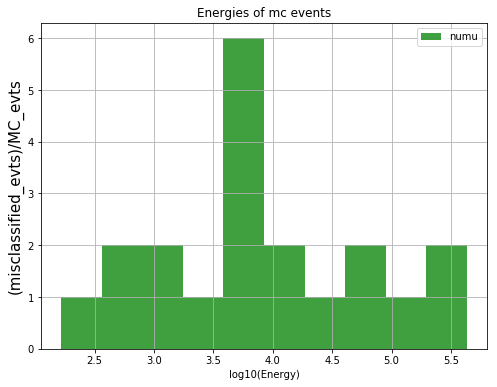

In [50]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(np.log10(E_numu_[wrong_class_evt_numu]), normed=False, facecolor='g', alpha=0.75, label="numu")
#plt.hist(np.log10(E_nue_[wrong_class_evt_nue]), normed=False,  facecolor="blue", alpha=0.5, label="nue")
#plt.hist(np.log10(E_numu_), normed=False, facecolor='b', alpha=0.5, label="numu")
#plt.plot(energy_bins[1:], fraction)

#plt.hist(np.log10(E_numu_), bins=energy_bins)
plt.xlabel("log10(Energy)")
plt.ylabel("(misclassified_evts)/MC_evts", size=15)
plt.xscale("linear")
plt.title('Energies of mc events')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [21]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)



In [22]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9)


In [53]:
wrong_class_evt_numu

array([ 675,  587,  799, 1283,  713,  525,  470,  551, 1013,  215,  441,
        875, 1003, 1491, 1076,  730,   14,   46, 1101,   40])

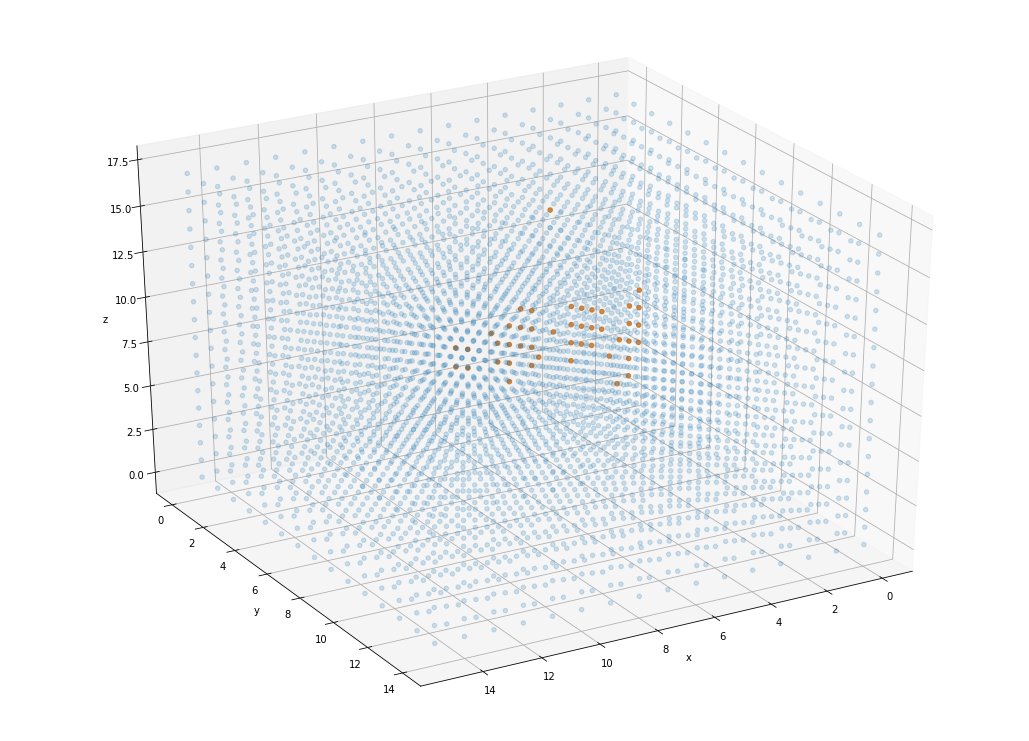

In [58]:
% matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,10))
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#for evt in wrong_class_evt_numu:
#    plot_x_evt(evt)
plot_x_evt(610)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [84]:
Xy_numu2 = np.load("Xy_numu2_sel5.npz")
Xy_nue2 = np.load("Xy_nue2_sel5.npz")


X_numu2 = Xy_numu2["x"]
y_numu2 = Xy_numu2["y"]


X_nue2 = Xy_nue2["x"]
y_nue2 = Xy_nue2["y"]



In [85]:
print('X_numu2: ', X_numu2.shape, 'X_nue2: ', X_nue2.shape, 'y_num2u: ', y_numu2.shape, 'y_nue2: ', y_nue2.shape)

('X_numu2: ', (1533, 75, 16, 15, 18), 'X_nue2: ', (1104, 75, 16, 15, 18), 'y_num2u: ', (1533,), 'y_nue2: ', (1104,))


In [86]:
X2 = np.vstack((X_numu2, X_nue2))
y2 = np.hstack((y_numu2, y_nue2))

In [60]:
np.random.shuffle?

In [87]:
indices = range(y2.size)

In [89]:
np.random.shuffle(indices)

In [90]:
sh_X2 = X2[indices]

In [91]:
sh_y2 = y2[indices]

In [92]:
sh_y2[:10]

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0], dtype=uint8)

In [94]:
print("Use model to make prediction on new data")
predictions = model.predict(sh_X2)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(sh_y2, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on new data
('Accuracy score: ', 0.8555176336746303)


In [102]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(sh_y2, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = np.where(cls_predictions!=sh_y2)[0]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,sh_y2.size,
                                                            np.true_divide((sh_y2.size-wrong_class_evt.size),sh_y2.size)))


Confusion matrix: 
[[1042   62]
 [ 319 1214]]
indices of the wrongly classified events: 
[   0    1    2    6   16   18   46   47   49   66   75   95  103  106  107
  110  114  122  124  128  129  136  153  164  176  198  208  211  220  222
  226  227  228  240  245  250  260  274  277  279  280  283  291  299  300
  308  312  333  342  347  350  352  353  354  359  368  442  444  455  459
  461  467  469  480  492  497  499  504  506  509  512  519  523  524  536
  542  546  548  560  567  569  577  582  585  588  589  590  595  596  598
  600  602  603  630  631  632  635  638  650  651  673  685  687  688  689
  696  720  724  730  733  734  737  756  763  782  791  792  793  797  798
  799  807  822  825  827  831  832  844  846  849  862  865  869  874  883
  904  906  910  917  925  926  936  948  952  957  962  969  970  971  978
  992  993 1005 1010 1014 1015 1018 1019 1027 1028 1029 1036 1050 1054 1063
 1067 1090 1095 1115 1136 1150 1160 1162 1176 1182 1191 1192 1195 1202 1204

In [103]:
wrong_class_evt_numu2 = wrong_class_evt[wrong_class_evt<X_numu2.shape[0]]


wrong_class_evt_nue2 = wrong_class_evt[wrong_class_evt>X_numu2.shape[0]] - X_numu2.shape[0]




In [104]:
wrong_class_evt_numu2

array([   0,    1,    2,    6,   16,   18,   46,   47,   49,   66,   75,
         95,  103,  106,  107,  110,  114,  122,  124,  128,  129,  136,
        153,  164,  176,  198,  208,  211,  220,  222,  226,  227,  228,
        240,  245,  250,  260,  274,  277,  279,  280,  283,  291,  299,
        300,  308,  312,  333,  342,  347,  350,  352,  353,  354,  359,
        368,  442,  444,  455,  459,  461,  467,  469,  480,  492,  497,
        499,  504,  506,  509,  512,  519,  523,  524,  536,  542,  546,
        548,  560,  567,  569,  577,  582,  585,  588,  589,  590,  595,
        596,  598,  600,  602,  603,  630,  631,  632,  635,  638,  650,
        651,  673,  685,  687,  688,  689,  696,  720,  724,  730,  733,
        734,  737,  756,  763,  782,  791,  792,  793,  797,  798,  799,
        807,  822,  825,  827,  831,  832,  844,  846,  849,  862,  865,
        869,  874,  883,  904,  906,  910,  917,  925,  926,  936,  948,
        952,  957,  962,  969,  970,  971,  978,  9

In [106]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu2[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9)


### try  conv3d without time
#### X has been summed over times and reshaped to (n_events, 1, conv_dim1, conv_dim2, conv_dim3)

In [25]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   3584      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

Train on 1369 samples, validate on 683 samples
Epoch 1/30
1369/1369 [==============================] - 12s - loss: 0.6744 - acc: 0.5866 - val_loss: 0.6810 - val_acc: 0.5827
Epoch 2/30
1369/1369 [==============================] - 12s - loss: 0.6563 - acc: 0.5822 - val_loss: 0.6310 - val_acc: 0.5827
Epoch 3/30
1369/1369 [==============================] - 12s - loss: 0.6038 - acc: 0.6209 - val_loss: 0.6956 - val_acc: 0.5842
Epoch 4/30
1369/1369 [==============================] - 12s - loss: 0.5165 - acc: 0.7509 - val_loss: 0.7011 - val_acc: 0.6413
Epoch 5/30
1369/1369 [==============================] - 12s - loss: 0.4429 - acc: 0.7999 - val_loss: 1.0924 - val_acc: 0.6208
Epoch 6/30
1369/1369 [==============================] - 12s - loss: 0.4116 - acc: 0.8188 - val_loss: 0.4924 - val_acc: 0.7833
Epoch 7/30
1369/1369 [==============================] - 12s - loss: 0.3478 - acc: 0.8517 - val_loss: 0.4464 - val_acc: 0.7994
Epoch 8/30
1369/1369 [==============================] - 12s - loss: 0.3

In [25]:
 %matplotlib inline
history_plot.history_plot_cv(history_info,"", "show", K=n_splits, N=n_iterations)

AttributeError: 'function' object has no attribute 'history_plot_cv'

In [26]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 32, 'epochs': 50, 'callbacks': [early_stop], 'verbose': 1}
history_info_50 = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   3584      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

1369/1369 [==============================] - 2s - loss: 0.2169 - acc: 0.9094 - val_loss: 0.2414 - val_acc: 0.9004
Epoch 10/50
1369/1369 [==============================] - 2s - loss: 0.1878 - acc: 0.9248 - val_loss: 0.2406 - val_acc: 0.9063
Epoch 11/50
1369/1369 [==============================] - 2s - loss: 0.1661 - acc: 0.9306 - val_loss: 0.2367 - val_acc: 0.9063
Epoch 12/50
1369/1369 [==============================] - 2s - loss: 0.1507 - acc: 0.9445 - val_loss: 0.2339 - val_acc: 0.9063
Epoch 13/50
1369/1369 [==============================] - 2s - loss: 0.1446 - acc: 0.9511 - val_loss: 0.2323 - val_acc: 0.9122
Epoch 14/50
1369/1369 [==============================] - 2s - loss: 0.1208 - acc: 0.9525 - val_loss: 0.2362 - val_acc: 0.9107
Epoch 15/50
1369/1369 [==============================] - 2s - loss: 0.1089 - acc: 0.9598 - val_loss: 0.2328 - val_acc: 0.9151
Epoch 16/50
1369/1369 [==============================] - 2s - loss: 0.1085 - acc: 0.9598 - val_loss: 0.2418 - val_acc: 0.9107
Epoc

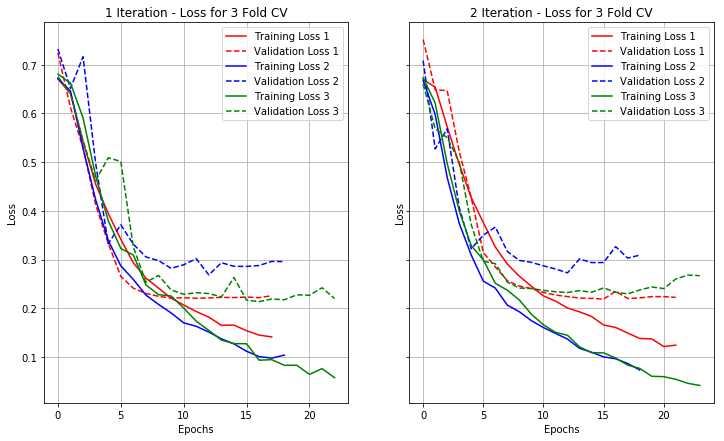

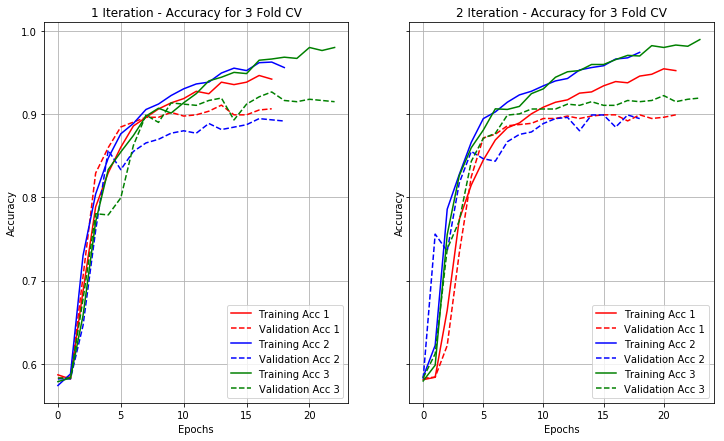

In [30]:
 %matplotlib inline
history_plot.history_plot_cv(history_info_50,"", "show", K=n_splits, N=n_iterations)

In [31]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 128, 'epochs': 50, 'callbacks': [early_stop], 'verbose': 1}
history_info_128_50 = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   3584      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

1367/1367 [==============================] - 2s - loss: 0.5126 - acc: 0.7366 - val_loss: 0.4611 - val_acc: 0.8161
Epoch 8/50
1367/1367 [==============================] - 2s - loss: 0.4604 - acc: 0.7827 - val_loss: 0.7904 - val_acc: 0.6569
Epoch 9/50
1367/1367 [==============================] - 2s - loss: 0.5077 - acc: 0.7718 - val_loss: 0.4045 - val_acc: 0.8321
Epoch 10/50
1367/1367 [==============================] - 2s - loss: 0.4042 - acc: 0.8186 - val_loss: 0.3758 - val_acc: 0.8438
Epoch 11/50
1367/1367 [==============================] - 2s - loss: 0.3953 - acc: 0.8215 - val_loss: 0.3506 - val_acc: 0.8599
Epoch 12/50
1367/1367 [==============================] - 2s - loss: 0.3787 - acc: 0.8325 - val_loss: 0.3360 - val_acc: 0.8657
Epoch 13/50
1367/1367 [==============================] - 2s - loss: 0.3604 - acc: 0.8456 - val_loss: 0.3412 - val_acc: 0.8569
Epoch 14/50
1367/1367 [==============================] - 2s - loss: 0.3574 - acc: 0.8464 - val_loss: 0.3044 - val_acc: 0.8701
Epoch 

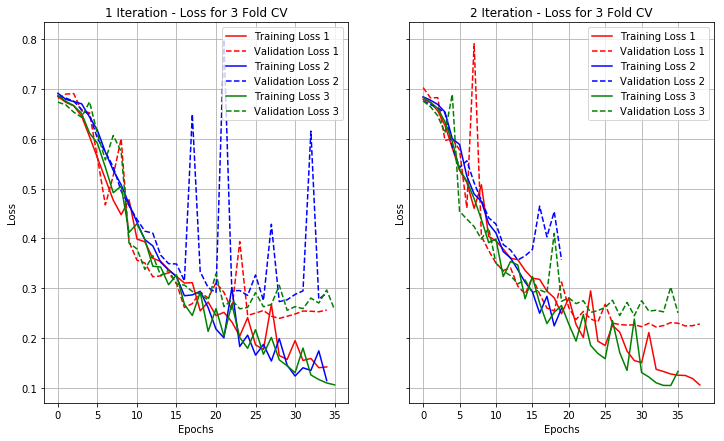

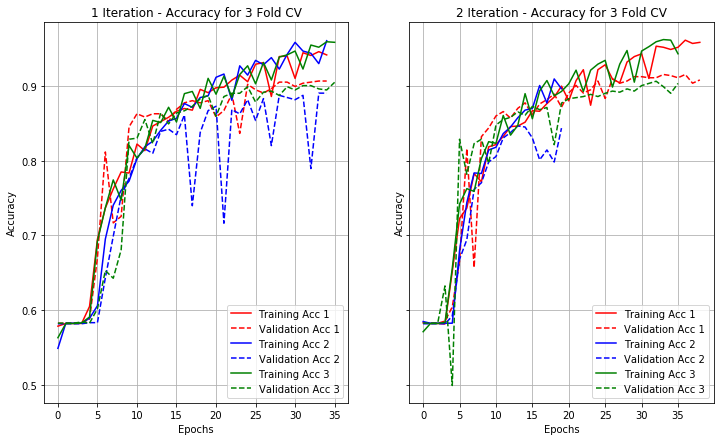

In [32]:
 %matplotlib inline
history_plot.history_plot_cv(history_info_128_50,"", "show", K=n_splits, N=n_iterations)

In [33]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 32, 'epochs': 50, 'callbacks': [early_stop], 'verbose': 1}
history_info_32_50 = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   3584      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

1369/1369 [==============================] - 2s - loss: 0.1447 - acc: 0.9467 - val_loss: 0.2372 - val_acc: 0.9048
Epoch 13/50
1369/1369 [==============================] - 2s - loss: 0.1396 - acc: 0.9408 - val_loss: 0.2366 - val_acc: 0.9063
Epoch 14/50
1369/1369 [==============================] - 2s - loss: 0.1258 - acc: 0.9518 - val_loss: 0.2341 - val_acc: 0.90630.950
Epoch 15/50
1369/1369 [==============================] - 2s - loss: 0.1029 - acc: 0.9598 - val_loss: 0.2334 - val_acc: 0.9122
Epoch 16/50
1369/1369 [==============================] - 2s - loss: 0.0953 - acc: 0.9613 - val_loss: 0.2402 - val_acc: 0.9063
Epoch 17/50
1369/1369 [==============================] - 2s - loss: 0.0922 - acc: 0.9642 - val_loss: 0.2394 - val_acc: 0.9092
Epoch 18/50
1369/1369 [==============================] - 2s - loss: 0.0843 - acc: 0.9664 - val_loss: 0.2365 - val_acc: 0.9048
Epoch 19/50
1369/1369 [==============================] - 2s - loss: 0.0713 - acc: 0.9759 - val_loss: 0.2449 - val_acc: 0.9136

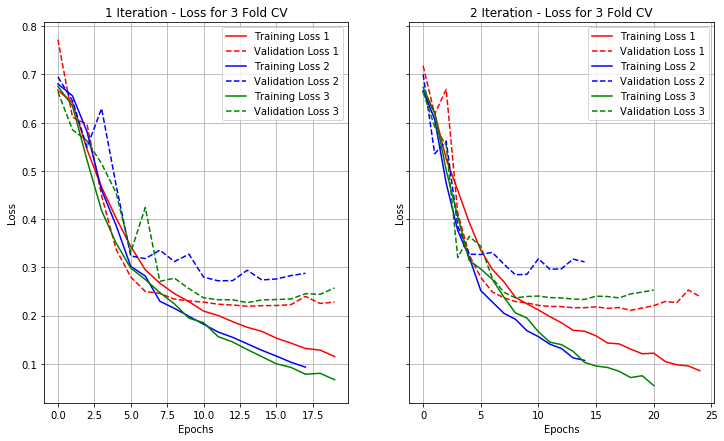

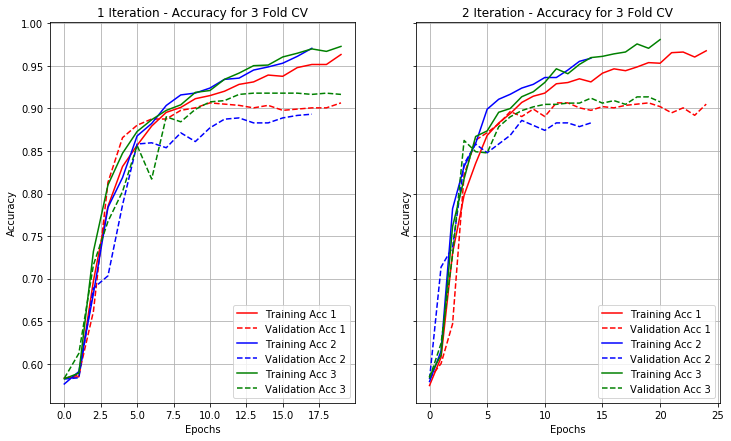

In [34]:
 %matplotlib inline
history_plot.history_plot_cv(history_info_32_50,"", "show", K=n_splits, N=n_iterations)

In [35]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adagrad()}
fitargs = {'batch_size': 32, 'epochs': 50, 'callbacks': [early_stop], 'verbose': 1}
history_info_32_50_Grad = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   3584      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

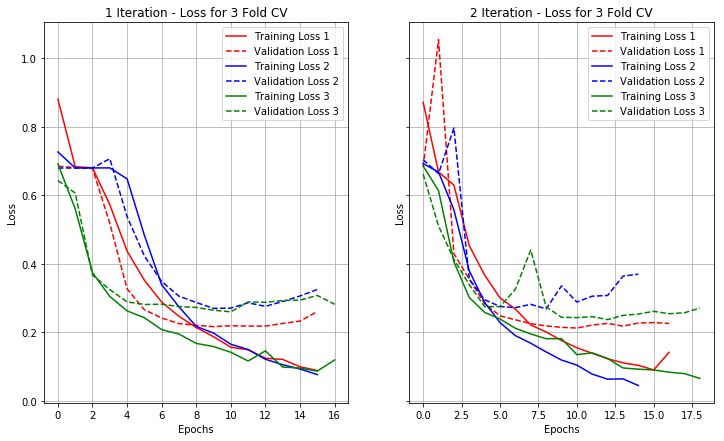

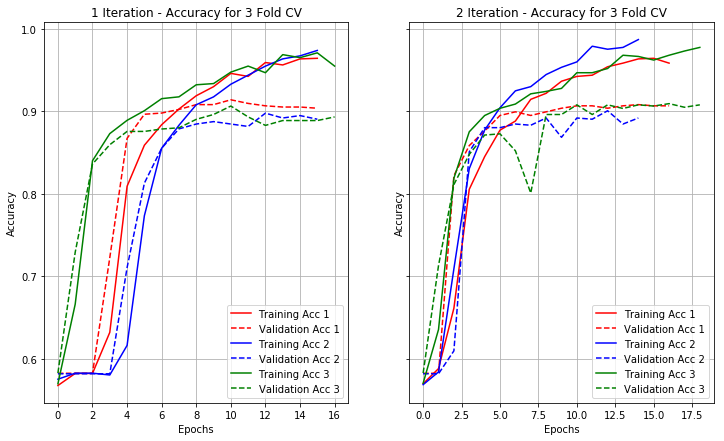

In [36]:
 %matplotlib inline
history_plot.history_plot_cv(history_info_32_50_Grad,"", "show", K=n_splits, N=n_iterations)

In [24]:
from keras.layers import Input, Conv3D
from keras.models import Model

In [25]:
inputshape

(1, 16, 15, 18)

In [81]:
from keras.layers import Input
from keras.models import Model

def vgg_inspired(input_shape, num_classes, optimizer):
    input_layer = Input(shape=input_shape)
    
    # Block 1
    x = Conv3D(32, kernel_size=(3, 3, 3), activation='selu', padding='same', name='block1_conv1')(input_layer)
    x = Conv3D(32, kernel_size=(3, 3, 3), activation='selu', padding='same', name='block1_conv2')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='block1_pool')(x)
    
    # Block 2
    x = Conv3D(64, kernel_size=(3, 3, 3), activation='selu', padding='same', name='block2_conv1')(x)
    x = Conv3D(64, kernel_size=(3, 3, 3), activation='selu', padding='same', name='block2_conv2')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='block2_pool')(x)
    
    # Block 3
    x = Conv3D(128, kernel_size=(3, 3, 3), activation='selu', padding='same', name='block3_conv2')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='same', name='block3_pool')(x)
    
    # top
    x = Flatten(name='flatten')(x)
    x = Dense(256,activation='selu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(input_layer, predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

### VGG Inspired Conv

In [26]:
X_train_notime.shape

(2052, 1, 16, 15, 18)

In [27]:
y_train.shape

(2052,)

In [56]:
n_splits = 3
n_iterations = 2
fargs = {'input_shape': inputshape, 'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=vgg_inspired, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 16, 15, 18)     0         
_________________________________________________________________
block1_conv1 (Conv3D)        (None, 32, 16, 15, 18)    896       
_________________________________________________________________
block1_conv2 (Conv3D)        (None, 32, 16, 15, 18)    27680     
_________________________________________________________________
block1_pool (MaxPooling3D)   (None, 32, 8, 8, 9)       0         
_________________________________________________________________
block2_conv1 (Conv3D)        (None, 64, 8, 8, 9)       55360     
_________________________________________________________________
block2_conv2 (Conv3D)        (None, 64, 8, 8, 9)       110656    
_________________________________________________________________
block2_pool (MaxPooling3D)   (None, 64, 4, 4, 

Train on 1368 samples, validate on 684 samples
Epoch 1/30
1368/1368 [==============================] - 15s - loss: 0.6821 - acc: 0.5782 - val_loss: 0.6751 - val_acc: 0.5819
Epoch 2/30
1368/1368 [==============================] - 15s - loss: 0.6572 - acc: 0.5885 - val_loss: 0.6858 - val_acc: 0.5819
Epoch 3/30
1368/1368 [==============================] - 15s - loss: 0.6233 - acc: 0.6732 - val_loss: 0.5806 - val_acc: 0.5848
Epoch 4/30
1368/1368 [==============================] - 15s - loss: 0.5578 - acc: 0.7383 - val_loss: 0.5894 - val_acc: 0.6506
Epoch 5/30
1368/1368 [==============================] - 15s - loss: 0.4407 - acc: 0.7749 - val_loss: 0.4763 - val_acc: 0.7515
Epoch 6/30
1368/1368 [==============================] - 15s - loss: 0.3348 - acc: 0.8436 - val_loss: 0.3902 - val_acc: 0.8041
Epoch 7/30
1368/1368 [==============================] - 15s - loss: 0.2629 - acc: 0.8874 - val_loss: 0.2833 - val_acc: 0.8684
Epoch 8/30
1368/1368 [==============================] - 15s - loss: 0.2

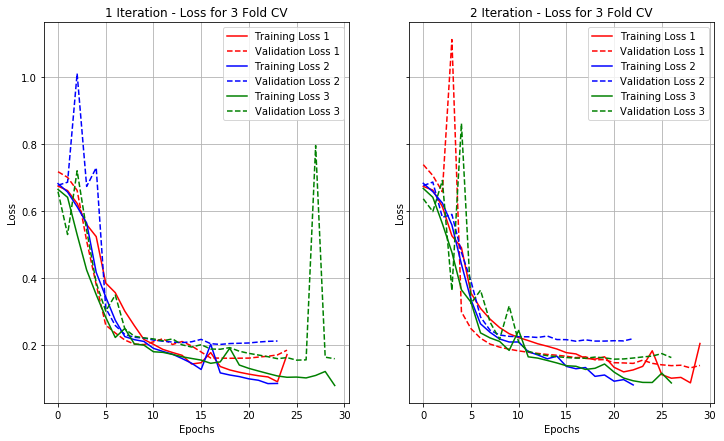

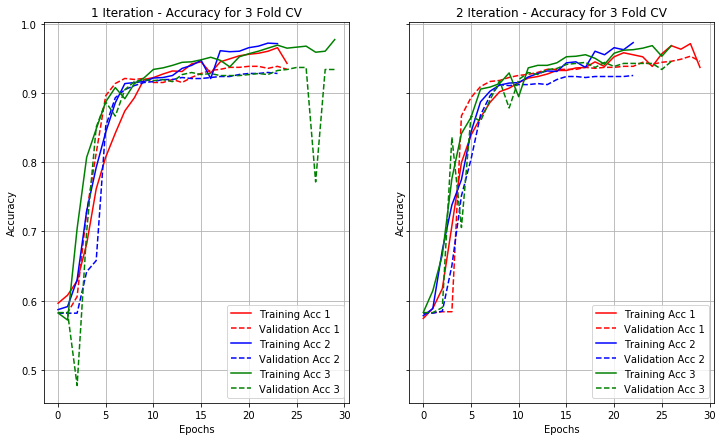

In [62]:
 %matplotlib inline
history_plot_cv(history_info,"", "show", K=n_splits, N=n_iterations)

In [74]:
model = vgg_inspired(inputshape, 2, keras.optimizers.Adadelta())
history = model.fit(X_train_notime, to_categorical(y_train), epochs=30, batch_size=32, 
                    callbacks=[early_stop_noval])

Epoch 1/30
2052/2052 [==============================] - 20s - loss: 0.6352 - acc: 0.6131    
Epoch 2/30
2052/2052 [==============================] - 20s - loss: 0.4143 - acc: 0.8021    
Epoch 3/30
2052/2052 [==============================] - 20s - loss: 0.2794 - acc: 0.8816    
Epoch 4/30
2052/2052 [==============================] - 20s - loss: 0.2189 - acc: 0.9079    
Epoch 5/30
2052/2052 [==============================] - 20s - loss: 0.2052 - acc: 0.9186    
Epoch 6/30
2052/2052 [==============================] - 20s - loss: 0.1780 - acc: 0.9303    
Epoch 7/30
2052/2052 [==============================] - 20s - loss: 0.1697 - acc: 0.9371    
Epoch 8/30
2052/2052 [==============================] - 20s - loss: 0.1585 - acc: 0.9401    
Epoch 9/30
2052/2052 [==============================] - 20s - loss: 0.1572 - acc: 0.9405    
Epoch 10/30
2052/2052 [==============================] - 20s - loss: 0.1487 - acc: 0.9435    
Epoch 11/30
2052/2052 [==============================] - 20s - loss: 

In [77]:
import history_plot
reload(history_plot)

<module 'history_plot' from 'history_plot.py'>

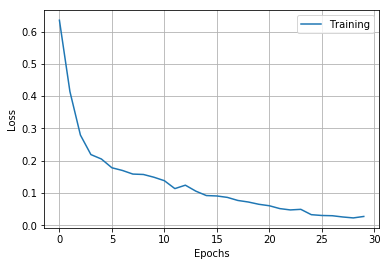

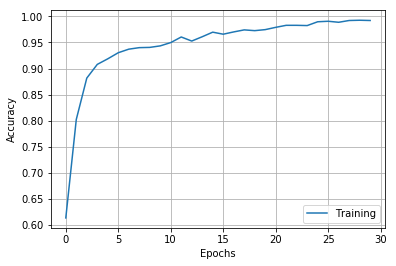

In [78]:
history_plot.history_plot(history, "", "show")

In [69]:
X_test_notime = X_test.reshape(X_test.shape[0], 1, 16, 15, 18)

In [79]:
predictions = model.predict(X_test_notime)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)


('Accuracy score: ', 0.94152046783625731)



### testing vgg_inspired with `'selu'`activation function

In [82]:
n_splits = 3
n_iterations = 2
fargs = {'input_shape': inputshape, 'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info_selu = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train_notime, y_train=y_train, 
                                      f_model=vgg_inspired, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1, 16, 15, 18)     0         
_________________________________________________________________
block1_conv1 (Conv3D)        (None, 32, 16, 15, 18)    896       
_________________________________________________________________
block1_conv2 (Conv3D)        (None, 32, 16, 15, 18)    27680     
_________________________________________________________________
block1_pool (MaxPooling3D)   (None, 32, 8, 8, 9)       0         
_________________________________________________________________
block2_conv1 (Conv3D)        (None, 64, 8, 8, 9)       55360     
_________________________________________________________________
block2_conv2 (Conv3D)        (None, 64, 8, 8, 9)       110656    
_________________________________________________________________
block2_pool (MaxPooling3D)   (None, 64, 4, 4, 

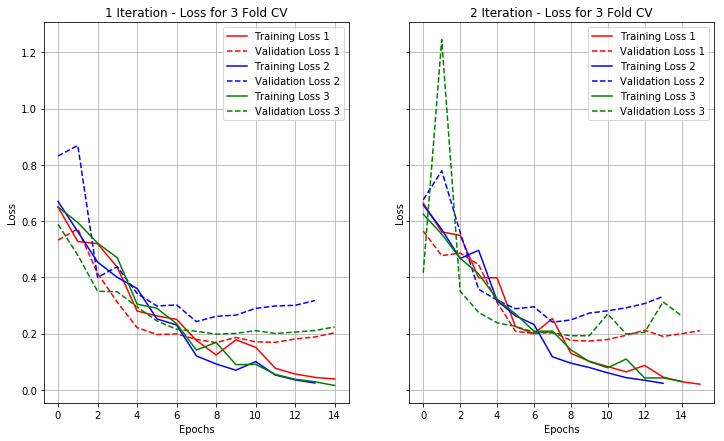

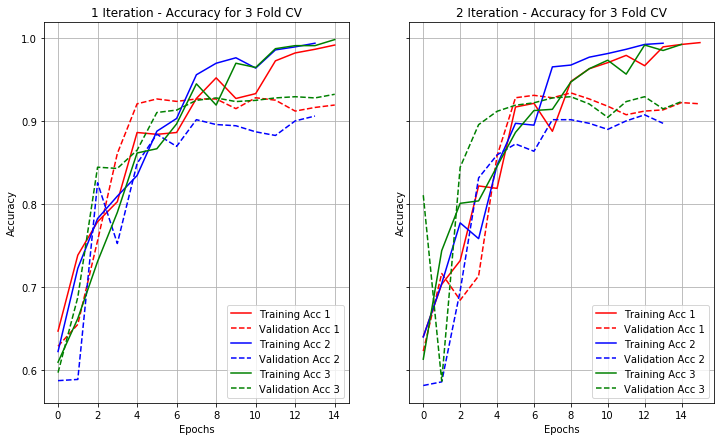

In [86]:
history_plot.history_plot_cv(history_info_selu, "", "show", K=n_splits, N=n_iterations)

In [88]:
model2 = vgg_inspired(inputshape, 2, keras.optimizers.Adadelta())
history_selu = model2.fit(X_train_notime, to_categorical(y_train), epochs=30, batch_size=32, 
                    callbacks=[early_stop_noval])

Epoch 1/30
2052/2052 [==============================] - 21s - loss: 0.6148 - acc: 0.6574    
Epoch 2/30
2052/2052 [==============================] - 20s - loss: 0.4479 - acc: 0.7904    
Epoch 3/30
2052/2052 [==============================] - 20s - loss: 0.3326 - acc: 0.8519    
Epoch 4/30
2052/2052 [==============================] - 21s - loss: 0.2355 - acc: 0.8972    
Epoch 5/30
2052/2052 [==============================] - 21s - loss: 0.1714 - acc: 0.9313    
Epoch 6/30
2052/2052 [==============================] - 21s - loss: 0.1335 - acc: 0.9444    
Epoch 7/30
2052/2052 [==============================] - 21s - loss: 0.0997 - acc: 0.9639    
Epoch 8/30
2052/2052 [==============================] - 21s - loss: 0.0895 - acc: 0.9683    
Epoch 9/30
2052/2052 [==============================] - 21s - loss: 0.0408 - acc: 0.9883    
Epoch 10/30
2052/2052 [==============================] - 21s - loss: 0.0478 - acc: 0.9839    
Epoch 11/30
2052/2052 [==============================] - 21s - loss: 

In [89]:
predictions = model2.predict(X_test_notime)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)


('Accuracy score: ', 0.92007797270955161)


### Try separating channels

In [38]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 75, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer, include_dense)
    xy_branch = _conv_block(xy_layer, include_dense)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [39]:
ZT_train = np.sum(X_train, axis=(2, 3))
XY_train = np.sum(X_train, axis=(1, 4))

ZT_train = ZT_train[:, np.newaxis, ...]
XY_train = XY_train[:, np.newaxis, ...]

In [40]:
ZT_test = np.sum(X_test, axis=(2, 3))
XY_test = np.sum(X_test, axis=(1, 4))

ZT_test = ZT_test[:, np.newaxis, ...]
XY_test = XY_test[:, np.newaxis, ...]

In [41]:
ZT_train.shape

(2052, 1, 75, 18)

In [42]:
XY_train.shape

(2052, 1, 16, 15)

In [43]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

In [46]:
fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)

Epoch 1/30
2052/2052 [==============================] - 1s - loss: 0.0716 - acc: 0.9747     
Epoch 2/30
2052/2052 [==============================] - 1s - loss: 0.0641 - acc: 0.9795     
Epoch 3/30
2052/2052 [==============================] - 1s - loss: 0.0750 - acc: 0.9747     
Epoch 4/30
2052/2052 [==============================] - 1s - loss: 0.0552 - acc: 0.9825     
Epoch 5/30
2052/2052 [==============================] - 1s - loss: 0.0577 - acc: 0.9810     
Epoch 6/30
2052/2052 [==============================] - 1s - loss: 0.0569 - acc: 0.9800     
Epoch 7/30
2052/2052 [==============================] - 1s - loss: 0.0495 - acc: 0.9820     
Epoch 8/30
2052/2052 [==============================] - 1s - loss: 0.0479 - acc: 0.9834     
Epoch 9/30
2052/2052 [==============================] - 1s - loss: 0.0505 - acc: 0.9849     
Epoch 10/30
2052/2052 [==============================] - 1s - loss: 0.0650 - acc: 0.9805     
Epoch 11/30
2052/2052 [==============================] - 1s - loss: 0

In [47]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.97270955165692008)


In [29]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.96881091617933723)


###  try again

In [24]:
early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)
reduce_lr_noval = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

In [50]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

fitargs = {'batch_size': 64, 'epochs': 30, 'verbose': 1, 'callbacks':[early_stop_noval]}
history_vgg_sep = vgg_sep_model.fit([ZT_train, XY_train], to_categorical(y_train), **fitargs)


Epoch 1/30
2052/2052 [==============================] - 8s - loss: 0.5288 - acc: 0.7320     
Epoch 2/30
2052/2052 [==============================] - 7s - loss: 0.2549 - acc: 0.9089     
Epoch 3/30
2052/2052 [==============================] - 7s - loss: 0.1977 - acc: 0.9211     
Epoch 4/30
2052/2052 [==============================] - 7s - loss: 0.1738 - acc: 0.9332     
Epoch 5/30
2052/2052 [==============================] - 7s - loss: 0.1522 - acc: 0.9430     
Epoch 6/30
2052/2052 [==============================] - 7s - loss: 0.1382 - acc: 0.9479     
Epoch 7/30
2052/2052 [==============================] - 7s - loss: 0.1353 - acc: 0.9532     
Epoch 8/30
2052/2052 [==============================] - 7s - loss: 0.1354 - acc: 0.9542     
Epoch 9/30
2052/2052 [==============================] - 7s - loss: 0.1274 - acc: 0.9566     
Epoch 10/30
2052/2052 [==============================] - 7s - loss: 0.1144 - acc: 0.9635     
Epoch 11/30
2052/2052 [==============================] - 7s - loss: 0

In [52]:
vgg_sep_model.save("vgg_numu_nue_sep_model.h5")

In [51]:
print("Use model to make prediction on test data")
predictions = vgg_sep_model.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.96881091617933723)


In [19]:
model2=keras.models.load_model("vgg_numu_nue_sep_model.h5")

In [26]:
print("Use model to make prediction on test data")
predictions = model2.predict([ZT_test,XY_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.96881091617933723)


In [20]:
n_classes=2

In [27]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_test)[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [139]:
roc_auc_low_E = roc_curve_en(low_E_map)
roc_auc_mid_E = roc_curve_en(medium_E_map)
roc_auc_high_E = roc_curve_en(high_E_map)


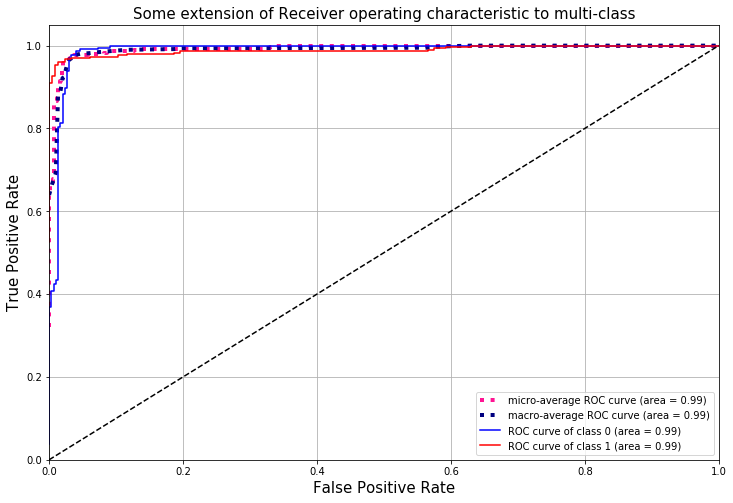

In [31]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
% matplotlib inline
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['blue', 'red', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Some extension of Receiver operating characteristic to multi-class', size=15)
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [33]:
import root_numpy as rnp
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')
E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])
E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])

In [35]:
numu_ids = np.load("numu_evt_sel_5_doms.npz")
nue_ids = np.load("nue_evt_sel_5_doms.npz")

numu_map = numu_ids["id"]
nue_map = nue_ids["id"]

E_numu_sel5 = E_numu_[numu_map]
E_nue_sel5 = E_nue_[nue_map]

Energies = np.hstack((E_numu_sel5, E_nue_sel5))

E_train, E_test = Energies[indx_train], Energies[indx_test]


In [39]:
np.min(E_test), np.max(E_test)

(3.2048100000000002, 78860900.0)

In [66]:
low_E_map = np.where(np.logical_and(E_test>1e0, E_test <1e3))[0]

In [67]:
medium_E_map = np.where(np.logical_and(E_test>1e3, E_test<1e5))[0]

In [68]:
high_E_map = np.where(np.logical_and(E_test>1e5, E_test<1e8))[0]

In [69]:
low_E_map.shape, medium_E_map.shape, high_E_map.shape

((100,), (307,), (106,))

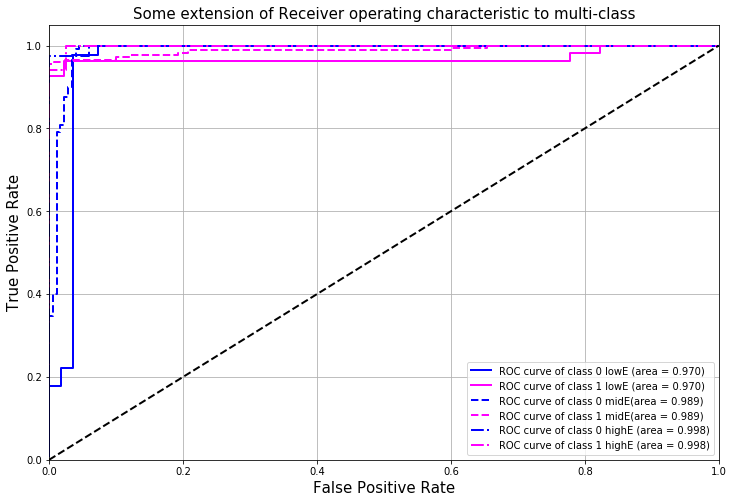

In [64]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc_function(E_map):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(to_categorical(y_test[E_map])[:,i], predictions[E_map][:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc


fpr_low, tpr_low, roc_auc_low = roc_auc_function(low_E_map)
fpr_mid, tpr_mid, roc_auc_mid = roc_auc_function(medium_E_map)
fpr_high, tpr_high, roc_auc_high = roc_auc_function(high_E_map)

def micro_macro(fpr,tpr):
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr["micro"],tpr["micro"], fpr["macro"], tpr["macro"]

fpr_m_lowE, tpr_m_lowE, fpr_M_lowE, tpr_M_lowE = micro_macro(fpr_low, tpr_low)
fpr_m_midE, tpr_m_midE, fpr_M_midE, tpr_M_midE = micro_macro(fpr_mid, tpr_mid)
fpr_m_highE, tpr_m_highE, fpr_M_highE, tpr_M_highE = micro_macro(fpr_high, tpr_high)

# Plot all ROC curves
plt.figure(figsize=(12,8))
"""
plt.plot(fpr_low["micro"], tpr_low["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_low["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_mid["micro"], tpr_mid["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mid["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_high["micro"], tpr_high["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_high["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_low["macro"], tpr_low["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_low["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot(fpr_mid["macro"], tpr_mid["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mid["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot(fpr_high["macro"], tpr_high["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_high["macro"]),
         color='navy', linestyle=':', linewidth=4)

"""
colors = cycle(['blue', 'magenta'])
lw=2

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_low[i], tpr_low[i], color=color, lw=lw,
             label='ROC curve of class {0} lowE (area = {1:0.3f})'
             ''.format(i, roc_auc_low[i]))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_mid[i], tpr_mid[i],'--', color=color, lw=lw,
             label='ROC curve of class {0} midE(area = {1:0.3f})'
             ''.format(i, roc_auc_mid[i]))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_high[i], tpr_high[i],'-.', color=color, lw=lw,
             label='ROC curve of class {0} highE (area = {1:0.3f})'
             ''.format(i, roc_auc_high[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Some extension of Receiver operating characteristic to multi-class', size=15)
plt.legend(loc="lower right")
plt.grid()
plt.show()

### try with multiple files

In [2]:
fnames_train = ["train_test_files/Xy_train"+str(i+1)+"_sel5_doms"+".npz" for i in range(100)]
fnames_test = ["train_test_files/Xy_test"+str(i+1)+"_sel5_doms"+".npz" for i in range(100)]

In [4]:
from multi_files_generator import Xy_gen

Using TensorFlow backend.


In [151]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    ZT_SHAPE = (1, 49, 18)
    XY_SHAPE = (1, 16, 15)
    
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    xy_layer = Input(shape=XY_SHAPE, name='xy_input')
    
    zt_branch = _conv_block(zt_layer)
    xy_branch = _conv_block(xy_layer)
    
    # top
    if include_dense:
        x = add([zt_branch, xy_branch], name='merge_add')
    else:
        x = concatenate([zt_branch, xy_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[zt_layer, xy_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [23]:
import multi_files_generator
reload(multi_files_generator)

<module 'multi_files_generator' from 'multi_files_generator.py'>

In [24]:
gen = multi_files_generator.Xy_gen_ZT_XY(fnames_test)

In [152]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

In [5]:
from multi_files_generator import Xy_gen_ZT_XY

In [153]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)

In [10]:
fitargs = {'steps_per_epoch' : 6525, 'callbacks' : [early_stop_noval, ModelCheckpoint("vgg_sep_ZT_XY_100files.hdf5")],
           'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit_generator(Xy_gen_ZT_XY(fnames_train), **fitargs)


Epoch 1/30
6525/6525 [==============================] - 444s - loss: 0.2002 - acc: 0.9243   
Epoch 2/30
6525/6525 [==============================] - 439s - loss: 0.1929 - acc: 0.9276   
Epoch 3/30
6525/6525 [==============================] - 451s - loss: 0.1879 - acc: 0.9299   - ETA: 4s - lo
Epoch 4/30
6525/6525 [==============================] - 455s - loss: 0.1835 - acc: 0.9317   
Epoch 5/30
6525/6525 [==============================] - 453s - loss: 0.1796 - acc: 0.9333   
Epoch 6/30
6525/6525 [==============================] - 454s - loss: 0.1758 - acc: 0.9352   
Epoch 7/30
6525/6525 [==============================] - 455s - loss: 0.1714 - acc: 0.9372   
Epoch 8/30
6525/6525 [==============================] - 452s - loss: 0.1673 - acc: 0.9384   
Epoch 9/30
6525/6525 [==============================] - 453s - loss: 0.1633 - acc: 0.9401   
Epoch 10/30
6525/6525 [==============================] - 454s - loss: 0.1593 - acc: 0.9413   
Epoch 11/30
6525/6525 [==============================] 

In [146]:
y_test = []
for i in range(100):
    y_test.append(np.load(fnames_train[i])["y"])

In [147]:
np.sum([len(y_test[i]) for i in range(100)])

208739

In [62]:
predictions_batch = []
for x,Y in next(Xy_gen_ZT_XY(fnames_test)):
    predictions = vgg_sep_model.predict(x[0], x[1],Y)
    predictions_batch.append(predictions)

ValueError: The model expects 2  arrays, but only received one array. Found: array with shape (1, 49, 18)

In [66]:
for x, Y in next(Xy_gen_ZT_XY(fnames_test)):
    print(x[0],x[1],Y)

(array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ValueError: too many values to unpack

In [80]:
predictions = vgg_sep_model.predict_generator(Xy_gen_ZT_XY(fnames_test), 1700, verbose=1)

1700/1700 [==============================] - 90s    


In [81]:
predictions.shape

(52651, 2)

In [111]:
ytest = []
pred=[]

In [112]:
LIMIT = 52235/32

In [115]:
for i, (X_test, y_test) in enumerate(Xy_gen_ZT_XY(fnames_test)):
    predictions = vgg_sep_model.predict(X_test, verbose=1)
    pred.append(predictions)
    ytest.append(y_test)
    if i==LIMIT:
        break

32/32 [==============================] - 0s


32/32 [==============================] - 0s


32/32 [==============================] - 0s


32/32 [==============================] - 0s


32/32 [==============================] - 0s


In [127]:
predicted_y = np.argmax(np.vstack(pred), axis=1)

In [136]:
y_real = np.vstack(np.asarray(ytest))

In [138]:
np.argmax(y_real, axis=)

array([1, 0, 0, ..., 1, 0, 1])

In [142]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)

In [143]:
score

0.91911343100618859

#### batch_size = 64

In [148]:
208739/64

3261

In [164]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)

In [165]:
fitargs = {'steps_per_epoch' : 3261, 
           'callbacks' : [early_stop_noval, ModelCheckpoint("vgg_sep_ZT_XY_100files_64.hdf5")],
           'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit_generator(Xy_gen_ZT_XY(fnames_train, batch_size=64), **fitargs)


Epoch 1/30
3261/3261 [==============================] - 409s - loss: 0.2296 - acc: 0.9118   
Epoch 2/30
3261/3261 [==============================] - 406s - loss: 0.2001 - acc: 0.9239   
Epoch 3/30
3261/3261 [==============================] - 402s - loss: 0.1932 - acc: 0.9270   
Epoch 4/30
3261/3261 [==============================] - 405s - loss: 0.1885 - acc: 0.9291   
Epoch 5/30
3261/3261 [==============================] - 401s - loss: 0.1848 - acc: 0.9306   
Epoch 6/30
3261/3261 [==============================] - 405s - loss: 0.1810 - acc: 0.9321   
Epoch 7/30
3261/3261 [==============================] - 401s - loss: 0.1769 - acc: 0.9340   
Epoch 8/30
3261/3261 [==============================] - 403s - loss: 0.1723 - acc: 0.9357   
Epoch 9/30
3261/3261 [==============================] - 402s - loss: 0.1674 - acc: 0.9379   
Epoch 10/30
3261/3261 [==============================] - 404s - loss: 0.1623 - acc: 0.9399   
Epoch 11/30
3261/3261 [==============================] - 402s - loss:

In [204]:
import keras

In [206]:
model = keras.models.load_model("vgg_sep_ZT_XY_100files_64.hdf5")

In [211]:
ytest=[]
pred=[]
for i, (X_test, y_test) in enumerate(Xy_gen_ZT_XY(fnames_test)):
    predictions = model.predict(X_test, verbose=1)
    pred.append(predictions)
    ytest.append(y_test)
    if i==LIMIT:
        break




32/32 [==============================] - 0s


32/32 [==============================] - 0s


32/32 [==============================] - 0s


32/32 [==============================] - 0s


32/32 [==============================] - 0s


In [249]:
ppred = np.vstack(pred)

In [255]:
ppred.shape

(50577, 2)

In [256]:
y_real.shape

(50577, 2)

In [261]:
ppred[:10], np.argmax(ppred, axis=1)

(array([[  6.01577098e-29,   1.00000000e+00],
        [  7.94729769e-01,   2.05270171e-01],
        [  6.70292675e-02,   9.32970762e-01],
        [  3.62490959e-17,   1.00000000e+00],
        [  9.87702429e-01,   1.22975474e-02],
        [  2.04063579e-21,   1.00000000e+00],
        [  9.88704264e-01,   1.12957554e-02],
        [  1.21879855e-13,   1.00000000e+00],
        [  2.28572455e-15,   1.00000000e+00],
        [  4.57980338e-15,   1.00000000e+00]], dtype=float32),
 array([1, 0, 1, ..., 1, 0, 1]))

In [258]:
y_real[:10]

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

array([ 1.,  0.,  0., ...,  1.,  0.,  1.])

In [212]:
len(ytest)

1633

In [213]:
len(pred)

1633

In [214]:
predicted_y = np.argmax(np.vstack(pred), axis=1)
y_real = np.vstack(np.asarray(ytest))

In [215]:
predicted_y.shape, y_real.shape

((50577,), (50577, 2))

In [216]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)

In [217]:
score

0.89058267591988449

In [218]:
to_categorical(predicted_y).shape

(50577, 2)

In [219]:
y_real.shape

(50577, 2)

In [198]:
y_real[:10], to_categorical(predicted_y)[:10]

(array([[ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]), array([[ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]]))

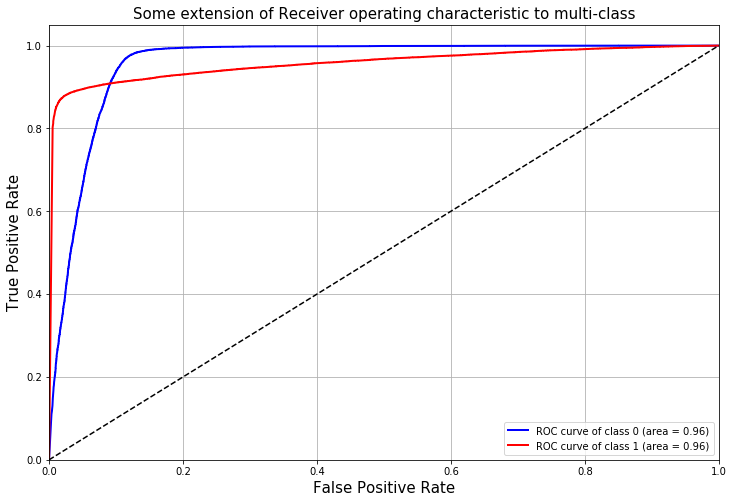

In [280]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from keras.utils import to_categorical
n_classes=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_real[:,i], ppred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_real[:,i].ravel(), ppred[:,i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
% matplotlib inline
plt.figure(figsize=(12,8))
"""
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
"""
colors = cycle(['blue', 'red', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Some extension of Receiver operating characteristic to multi-class', size=15)
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [240]:
roc_curve?

### Try separating XT, YT, ZT channels

In [34]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    XT_SHAPE = (1, 75, 16)
    YT_SHAPE = (1, 75, 15)
    ZT_SHAPE = (1, 75, 18)
    
    
    xt_layer = Input(shape=XT_SHAPE, name='xt_input')
    yt_layer = Input(shape=YT_SHAPE, name='yt_input')
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    xt_branch = _conv_block(xt_layer)#, include_dense)
    yt_branch = _conv_block(yt_layer)#, include_dense)
    zt_branch = _conv_block(zt_layer)#, include_dense)
    
    
    # top
    if include_dense:
        x = add([xt_branch, yt_branch, zt_branch], name='merge_add')
    else:
        x = concatenate([xt_branch, yt_branch, zt_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[xt_layer, yt_layer, zt_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [489]:
import multi_files_generator
reload(multi_files_generator)

<module 'multi_files_generator' from 'multi_files_generator.py'>

In [281]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)

fitargs = {'steps_per_epoch' : 6525, 'callbacks' : [early_stop_noval, ModelCheckpoint("vgg_sep_XT_YT_ZT_100files32.hdf5")],
           'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit_generator(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_train, batch_size=64), **fitargs)


Epoch 1/30
6525/6525 [==============================] - 1081s - loss: 0.2122 - acc: 0.9186  
Epoch 2/30
6525/6525 [==============================] - 1077s - loss: 0.1827 - acc: 0.9306  
Epoch 3/30
6525/6525 [==============================] - 1075s - loss: 0.1701 - acc: 0.9356  
Epoch 4/30
6525/6525 [==============================] - 1073s - loss: 0.1579 - acc: 0.9407  
Epoch 5/30
6525/6525 [==============================] - 1076s - loss: 0.1431 - acc: 0.9465  
Epoch 6/30
6525/6525 [==============================] - 1072s - loss: 0.1256 - acc: 0.9533  
Epoch 7/30
6525/6525 [==============================] - 1078s - loss: 0.1071 - acc: 0.9601  
Epoch 8/30
6525/6525 [==============================] - 1071s - loss: 0.0910 - acc: 0.9658  
Epoch 9/30
6525/6525 [==============================] - 1076s - loss: 0.0769 - acc: 0.9707  
Epoch 10/30
6525/6525 [==============================] - 1075s - loss: 0.0654 - acc: 0.9748  
Epoch 11/30
6525/6525 [==============================] - 1072s - loss

In [282]:
model = vgg_sep_model

In [346]:
LIMIT = 52235/64

In [421]:
g = []
for i in range(100):
    g.append(np.load(fnames_test[i])["y"])

In [427]:
count = []
for i in range(100):
    count.append(len(g[i]))


In [429]:
np.sum(count)

52235

In [650]:
LIMIT=87

In [651]:
ytest=[]
for i, (X_test, y_test) in enumerate(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_test)):
    ytest.append(y_test)
    if i==LIMIT:
        break

file 0 : train_test_files/Xy_test1_sel5_doms.npz
8
file 1 : train_test_files/Xy_test2_sel5_doms.npz
17
file 2 : train_test_files/Xy_test3_sel5_doms.npz
25
file 3 : train_test_files/Xy_test4_sel5_doms.npz
34
file 4 : train_test_files/Xy_test5_sel5_doms.npz
43
file 5 : train_test_files/Xy_test6_sel5_doms.npz
52
file 6 : train_test_files/Xy_test7_sel5_doms.npz
61
file 7 : train_test_files/Xy_test8_sel5_doms.npz
70
file 8 : train_test_files/Xy_test9_sel5_doms.npz
79
file 9 : train_test_files/Xy_test10_sel5_doms.npz
87
file 10 : train_test_files/Xy_test11_sel5_doms.npz


In [355]:
np.vstack(np.asarray(ytest)).shape

(48248, 2)

In [468]:
52235/64

816

In [386]:
hhhh = np.load(fnames_test[0])["y"]

In [387]:
hhhh.shape

(511,)

In [413]:
import multi_files_generator
reload(multi_files_generator)

<module 'multi_files_generator' from 'multi_files_generator.py'>

4051

In [458]:
LIMIT = 52235/64

In [454]:
52235/64

816

In [457]:
816*64 + 52235%64

52235

In [452]:
52235%64

11

In [493]:
ytest=[]
pred=[]
for i, (X_test, y_test) in enumerate(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_test)):
    predictions = model.predict(X_test, verbose=0)
    pred.append(predictions)
    ytest.append(y_test)
    print(y_test.shape[0])

    if i>LIMIT:
        print("limit reached! i=%d"%i)
        break

file 0 : train_test_files/Xy_test1_sel5_doms.npz
64
64
64
64
64
64
64
63
8
file 1 : train_test_files/Xy_test2_sel5_doms.npz
64
64
64
64
64
64
64
64
16
17
file 2 : train_test_files/Xy_test3_sel5_doms.npz
64
64
64
64
64
64
64
63
25
file 3 : train_test_files/Xy_test4_sel5_doms.npz
64
64
64
64
64
64
64
64
5
34
file 4 : train_test_files/Xy_test5_sel5_doms.npz
64
64
64
64
64
64
64
64
9
43
file 5 : train_test_files/Xy_test6_sel5_doms.npz
64
64
64
64
64
64
64
64
13
52
file 6 : train_test_files/Xy_test7_sel5_doms.npz
64
64
64
64
64
64
64
64
2
61
file 7 : train_test_files/Xy_test8_sel5_doms.npz
64
64
64
64
64
64
64
64
12
70
file 8 : train_test_files/Xy_test9_sel5_doms.npz
64
64
64
64
64
64
64
64
23
79
file 9 : train_test_files/Xy_test10_sel5_doms.npz
64
64
64
64
64
64
64
63
87
file 10 : train_test_files/Xy_test11_sel5_doms.npz
64
64
64
64
64
64
64
64
13
96
file 11 : train_test_files/Xy_test12_sel5_doms.npz
64
64
64
64
64
64
64
64
22
105
file 12 : train_test_files/Xy_test13_sel5_doms.npz
64
64
64

In [465]:
820*64

52480

In [501]:
pred = model.predict_generator(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_test),steps = 886)

file 0 : train_test_files/Xy_test1_sel5_doms.npz
8
file 1 : train_test_files/Xy_test2_sel5_doms.npz
17
file 2 : train_test_files/Xy_test3_sel5_doms.npz
25
file 3 : train_test_files/Xy_test4_sel5_doms.npz
34
file 4 : train_test_files/Xy_test5_sel5_doms.npz
43
file 5 : train_test_files/Xy_test6_sel5_doms.npz
52
file 6 : train_test_files/Xy_test7_sel5_doms.npz
61
file 7 : train_test_files/Xy_test8_sel5_doms.npz
70
file 8 : train_test_files/Xy_test9_sel5_doms.npz
79
file 9 : train_test_files/Xy_test10_sel5_doms.npz
87
file 10 : train_test_files/Xy_test11_sel5_doms.npz
96
file 11 : train_test_files/Xy_test12_sel5_doms.npz
105
file 12 : train_test_files/Xy_test13_sel5_doms.npz
113
file 13 : train_test_files/Xy_test14_sel5_doms.npz
121
file 14 : train_test_files/Xy_test15_sel5_doms.npz
130
file 15 : train_test_files/Xy_test16_sel5_doms.npz
139
file 16 : train_test_files/Xy_test17_sel5_doms.npz
148
file 17 : train_test_files/Xy_test18_sel5_doms.npz
157
file 18 : train_test_files/Xy_test19_sel5

In [503]:
ppred = np.vstack(pred)
ppred.shape

(52235, 2)

In [505]:
y_real = np.vstack(np.asarray(ytest[:-2]))
y_real.shape

(52235, 2)

In [506]:
predicted_y = np.argmax(pred, axis=1)

In [507]:
from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
score

0.89491720111036666

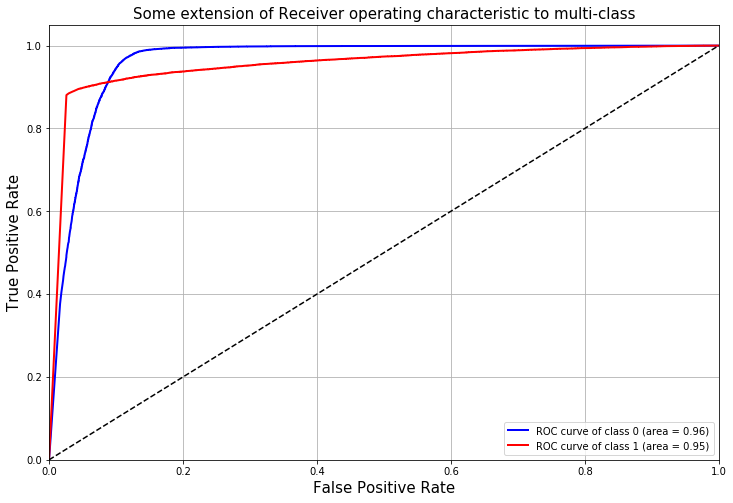

In [508]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from keras.utils import to_categorical
n_classes=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_real[:,i], ppred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_real[:,i].ravel(), ppred[:,i].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
% matplotlib inline
plt.figure(figsize=(12,8))
"""
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
"""
colors = cycle(['blue', 'red', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Some extension of Receiver operating characteristic to multi-class', size=15)
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [291]:
fname_indx_test = ["train_test_files/Xy_indx"+str(i+1)+"_sel5_doms"+".npz" for i in range(100)]

In [557]:
fname_indx_train = ["train_test_files/Xy_indx"+str(i+1)+"_sel5_doms"+".npz" for i in range(100)]

In [558]:
train_indices = [np.load(fname_indx_train[i])["train"] for i in range(100)]

In [299]:
test_indices = [np.load(fname_indx_test[i])["test"] for i in range(100)]

In [561]:
import root_numpy as rnp
def test_energies(numufile, nuefile, numu_map, nue_map, train_idx, test_idx):

    E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
    type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
    E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
    type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')
    E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])
    E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])


    E_numu_sel5 = E_numu_[numu_map]
    E_nue_sel5 = E_nue_[nue_map]

    Energies = np.hstack((E_numu_sel5, E_nue_sel5))

    E_train, E_test = Energies[train_idx], Energies[test_idx]
   # E_test = Energies[test_idx]
    return(E_train, E_test)

In [305]:
numufiles = ["aafiles/numu_files/numu_st_JTE_aa/km3_v4_numucc_"+str(i+1)+".evt.JTE.aa.root" for i in range(100)]

In [307]:
nuefiles = ["aafiles/nue_files/nue_st_JTE_aa/km3_v4_nuecc_"+str(i+1)+".evt.JTE.aa.root" for i in range(100)]

In [313]:
numu_maps = [np.load("aafiles/numu_files/numu_"+str(i+1)+"_sel5_doms_map.npz")["id"] for i in range(100)]
nue_maps = [np.load("aafiles/nue_files/nue_"+str(i+1)+"_sel_5_doms_map.npz")["id"] for i in range(100)]

In [ ]:
np.load("aafiles/nue_files/nue_100_sel_5_doms_map.npz")

In [320]:
E_test_1 = test_energies(numufiles[0],nuefiles[0],numu_maps[0], nue_maps[0], test_indices[0])

In [562]:
E_trains, E_tests = np.asarray([test_energies(numufiles[i],nuefiles[i],numu_maps[i], nue_maps[i], train_indices[i], test_indices[i]) for i in range(100)])

ValueError: too many values to unpack

In [512]:
E_test_tot = np.hstack(E_tests)

In [510]:
y_real.shape

(52235, 2)

In [539]:
low_E_map = np.where(np.logical_and(E_test_tot>0, E_test_tot <1e2))[0]
medium_E_map = np.where(np.logical_and(E_test_tot>1e2, E_test_tot<1e3))[0]
high_E_map = np.where(np.logical_and(E_test_tot>1e3, E_test_tot<1e8))[0]

low_E_map.shape, medium_E_map.shape, high_E_map.shape


((2307,), (31602,), (18326,))

In [537]:
from decimal import Decimal

In [538]:
Decimal(1e3)

Decimal('1000')

In [534]:
2307+31602+18326

52235

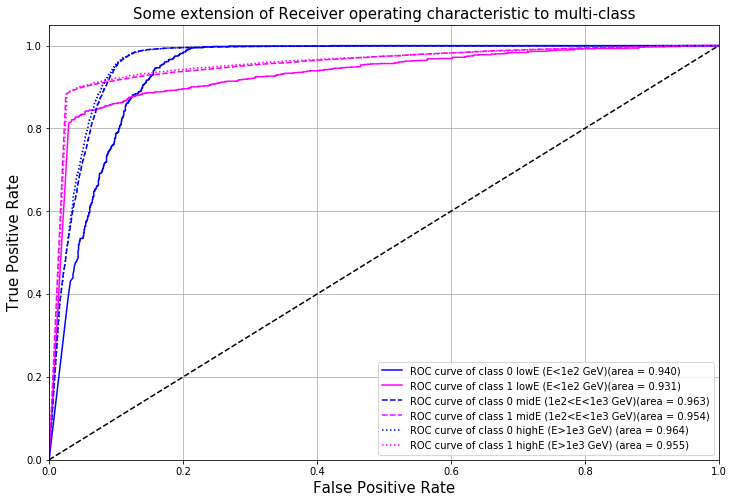

In [541]:

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc_function(E_map):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_real[E_map][:,i], ppred[E_map][:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

fpr_low, tpr_low, roc_auc_low = roc_auc_function(low_E_map)
fpr_mid, tpr_mid, roc_auc_mid = roc_auc_function(medium_E_map)
fpr_high, tpr_high, roc_auc_high = roc_auc_function(high_E_map)

def micro_macro(fpr,tpr):
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_real.ravel(), ppred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr["micro"],tpr["micro"], fpr["macro"], tpr["macro"]

fpr_m_lowE, tpr_m_lowE, fpr_M_lowE, tpr_M_lowE = micro_macro(fpr_low, tpr_low)
fpr_m_midE, tpr_m_midE, fpr_M_midE, tpr_M_midE = micro_macro(fpr_mid, tpr_mid)
fpr_m_highE, tpr_m_highE, fpr_M_highE, tpr_M_highE = micro_macro(fpr_high, tpr_high)

# Plot all ROC curves
plt.figure(figsize=(12,8))
"""
plt.plot(fpr_low["micro"], tpr_low["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_low["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_mid["micro"], tpr_mid["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mid["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_high["micro"], tpr_high["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_high["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_low["macro"], tpr_low["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_low["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot(fpr_mid["macro"], tpr_mid["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mid["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot(fpr_high["macro"], tpr_high["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_high["macro"]),
         color='navy', linestyle=':', linewidth=4)

"""
colors = cycle(['blue', 'magenta'])
lw=1.5

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_low[i], tpr_low[i], color=color, lw=lw,
             label='ROC curve of class {0} lowE (E<1e2 GeV)(area = {1:0.3f})'
             ''.format(i, roc_auc_low[i]))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_mid[i], tpr_mid[i],'--', color=color, lw=lw,
             label='ROC curve of class {0} midE (1e2<E<1e3 GeV)(area = {1:0.3f})'
             ''.format(i, roc_auc_mid[i]))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_high[i], tpr_high[i],':', color=color, lw=lw,
             label='ROC curve of class {0} highE (E>1e3 GeV) (area = {1:0.3f})'
             ''.format(i, roc_auc_high[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('Some extension of Receiver operating characteristic to multi-class', size=15)
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [543]:
E_test_tot.shape

(52235,)

(array([ 6685.,  3795.,  2694.,  1866.,  1246.,   911.,   595.,   312.,
          179.,    43.]),
 array([ 1000.11 ,  1498.378,  1996.646,  2494.914,  2993.182,  3491.45 ,
         3989.718,  4487.986,  4986.254,  5484.522,  5982.79 ]),
 <a list of 10 Patch objects>)

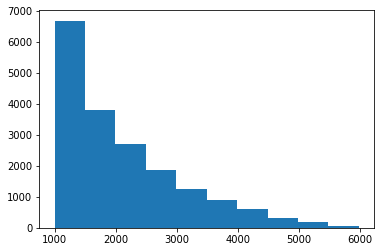

In [551]:
%matplotlib inline
plt.hist(E_test_tot[high_E_map])

In [553]:
np.min(E_test_tot[low_E_map]), np.max(E_test_tot[low_E_map])

(0.187306, 99.974599999999995)

In [554]:
np.min(E_test_tot[medium_E_map]), np.max(E_test_tot[medium_E_map])

(100.017, 999.82299999999998)

In [555]:
np.min(E_test_tot[high_E_map]), np.max(E_test_tot[high_E_map])

(1000.11, 5982.79)

In [643]:
# ytrain=[]
pred=[]
for i, (X_train, y_train) in enumerate(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_train[:10])):
    #predictions = model.predict(X_test, verbose=0)
    #pred.append(predictions)
    ytrain.append(y_train)
    print(y_train.shape[0])

    if i>LIMIT:
        print("limit reached! i=%d"%i)
        break

file 0 : train_test_files/Xy_train1_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
60
32
file 1 : train_test_files/Xy_train2_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
61
65
file 2 : train_test_files/Xy_train3_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
60
97
file 3 : train_test_files/Xy_train4_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
20
130
file 4 : train_test_files/Xy_train5_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
33
163
file 5 : train_test_files/Xy_train6_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
48
196
file 6 : train_test_files/Xy_train7_sel5_doms.npz
64
64
64
64
64
64
64
64
64
64
64
64
64
64

KeyboardInterrupt: 

In [567]:
fname_train_10 = fnames_train[:10]

In [568]:
len(fnames_train)

100

In [628]:
unique_fnames_train = []
for idx in unique_fnames_train_indx:
    unique_fnames_train.append(fnames_train[idx])

In [655]:
unique_fnames_train

['train_test_files/Xy_train1_sel5_doms.npz',
 'train_test_files/Xy_train2_sel5_doms.npz',
 'train_test_files/Xy_train4_sel5_doms.npz',
 'train_test_files/Xy_train5_sel5_doms.npz',
 'train_test_files/Xy_train6_sel5_doms.npz',
 'train_test_files/Xy_train7_sel5_doms.npz',
 'train_test_files/Xy_train8_sel5_doms.npz',
 'train_test_files/Xy_train9_sel5_doms.npz',
 'train_test_files/Xy_train11_sel5_doms.npz',
 'train_test_files/Xy_train12_sel5_doms.npz',
 'train_test_files/Xy_train13_sel5_doms.npz',
 'train_test_files/Xy_train14_sel5_doms.npz',
 'train_test_files/Xy_train15_sel5_doms.npz',
 'train_test_files/Xy_train16_sel5_doms.npz',
 'train_test_files/Xy_train17_sel5_doms.npz',
 'train_test_files/Xy_train18_sel5_doms.npz',
 'train_test_files/Xy_train19_sel5_doms.npz',
 'train_test_files/Xy_train21_sel5_doms.npz',
 'train_test_files/Xy_train22_sel5_doms.npz',
 'train_test_files/Xy_train23_sel5_doms.npz',
 'train_test_files/Xy_train24_sel5_doms.npz',
 'train_test_files/Xy_train26_sel5_doms.np

In [641]:
unique_numu_files_60 = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       20, 21, 22, 23, 25, 26, 27, 28, 30, 33, 35, 36, 37, 38, 40, 41, 42,
       43, 45, 47, 48, 51, 53, 54, 55, 56, 58, 61, 66, 67, 68, 70, 73, 75,
       76, 77, 78, 80, 82, 84, 87, 92, 94])

unique_nue_files_60 = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18,
       20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40,
       41, 43, 44, 45, 46, 47, 51, 52, 54, 55, 56, 58, 60, 61, 64, 65, 67,
       70, 71, 72, 75, 80, 82, 83, 84, 85])

In [644]:
fargs = {'num_classes': 2, 'optimizer': Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)

fitargs = {'steps_per_epoch' : 328, 'callbacks' : [early_stop_noval, ModelCheckpoint("vgg_sep_XT_YT_ZT_10files64.hdf5")],
           'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit_generator(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_train, batch_size=64), **fitargs)


Epoch 1/30
file 0 : train_test_files/Xy_train1_sel5_doms.npz
 22/328 [=>............................] - ETA: 81s - loss: 0.5532 - acc: 0.747232
file 1 : train_test_files/Xy_train2_sel5_doms.npz
 55/328 [====>.........................] - ETA: 57s - loss: 0.4631 - acc: 0.793365
file 2 : train_test_files/Xy_train3_sel5_doms.npz
 87/328 [======>.......................] - ETA: 47s - loss: 0.4121 - acc: 0.818497
file 3 : train_test_files/Xy_train4_sel5_doms.npz
120/328 [=========>....................] - ETA: 39s - loss: 0.3807 - acc: 0.8348130
file 4 : train_test_files/Xy_train5_sel5_doms.npz
153/328 [============>.................] - ETA: 32s - loss: 0.3624 - acc: 0.8445163
file 5 : train_test_files/Xy_train6_sel5_doms.npz
186/328 [================>.............] - ETA: 25s - loss: 0.3542 - acc: 0.8505196
file 6 : train_test_files/Xy_train7_sel5_doms.npz
219/328 [===================>..........] - ETA: 19s - loss: 0.3390 - acc: 0.8583229
file 7 : train_test_files/Xy_train8_sel5_doms.npz
252/

118/328 [=========>....................] - ETA: 31s - loss: 0.1934 - acc: 0.9250426
file 13 : train_test_files/Xy_train14_sel5_doms.npz
150/328 [============>.................] - ETA: 27s - loss: 0.1971 - acc: 0.9234458
file 14 : train_test_files/Xy_train15_sel5_doms.npz
183/328 [===============>..............] - ETA: 22s - loss: 0.2007 - acc: 0.9209491
file 15 : train_test_files/Xy_train16_sel5_doms.npz
216/328 [==================>...........] - ETA: 17s - loss: 0.2024 - acc: 0.9209524
file 16 : train_test_files/Xy_train17_sel5_doms.npz
249/328 [=====================>........] - ETA: 12s - loss: 0.2040 - acc: 0.9192557
file 17 : train_test_files/Xy_train18_sel5_doms.npz
282/328 [========================>.....] - ETA: 7s - loss: 0.2020 - acc: 0.9209590
file 18 : train_test_files/Xy_train19_sel5_doms.npz
315/328 [===========================>..] - ETA: 2s - loss: 0.2002 - acc: 0.9217623
file 19 : train_test_files/Xy_train20_sel5_doms.npz
328/328 [==============================] - 54s - l

280/328 [========================>.....] - ETA: 7s - loss: 0.1930 - acc: 0.9254886
file 27 : train_test_files/Xy_train28_sel5_doms.npz
313/328 [===========================>..] - ETA: 2s - loss: 0.1922 - acc: 0.9253919
file 28 : train_test_files/Xy_train29_sel5_doms.npz
328/328 [==============================] - 55s - loss: 0.1925 - acc: 0.9251    
Epoch 24/30
 18/328 [>.............................] - ETA: 21s - loss: 0.1791 - acc: 0.9297952
file 29 : train_test_files/Xy_train30_sel5_doms.npz
 52/328 [===>..........................] - ETA: 36s - loss: 0.1788 - acc: 0.9329986
file 30 : train_test_files/Xy_train31_sel5_doms.npz
 86/328 [======>.......................] - ETA: 35s - loss: 0.1813 - acc: 0.93391020
file 31 : train_test_files/Xy_train32_sel5_doms.npz
120/328 [=========>....................] - ETA: 31s - loss: 0.1832 - acc: 0.93191054
file 32 : train_test_files/Xy_train33_sel5_doms.npz
154/328 [=============>................] - ETA: 27s - loss: 0.1820 - acc: 0.93331088
file 33

In [645]:
history_vgg_sep.history["acc"]

[0.87250842609311385,
 0.90347826080621729,
 0.91107681922065942,
 0.91454192940552026,
 0.91374233700383578,
 0.91680733083040133,
 0.91973938242061259,
 0.92001744036976651,
 0.91922275532919195,
 0.92188945710005943,
 0.92508425705985031,
 0.92038262737298959,
 0.92331436313807336,
 0.92692493949906296,
 0.92335554910180517,
 0.9267411618468826,
 0.92598850987335446,
 0.92688713527179445,
 0.927465916452065,
 0.92800544462741297,
 0.93250794960694661,
 0.92622990382435366,
 0.92557915077188757,
 0.92973966906196004,
 0.92778073191821397,
 0.93010700858858641,
 0.93006756776318122]

In [646]:
pred = vgg_sep_model.predict_generator(multi_files_generator.Xy_gen_XT_YT_ZT(fnames_test),steps = 87)


file 0 : train_test_files/Xy_test1_sel5_doms.npz
8
file 1 : train_test_files/Xy_test2_sel5_doms.npz
17
file 2 : train_test_files/Xy_test3_sel5_doms.npz
25
file 3 : train_test_files/Xy_test4_sel5_doms.npz
34
file 4 : train_test_files/Xy_test5_sel5_doms.npz
43
file 5 : train_test_files/Xy_test6_sel5_doms.npz
52
file 6 : train_test_files/Xy_test7_sel5_doms.npz
61
file 7 : train_test_files/Xy_test8_sel5_doms.npz
70
file 8 : train_test_files/Xy_test9_sel5_doms.npz
79
file 9 : train_test_files/Xy_test10_sel5_doms.npz
87
file 10 : train_test_files/Xy_test11_sel5_doms.npz


In [648]:

ppred = np.vstack(pred)
ppred.shape

(5197, 2)

In [653]:

y_real = np.vstack(np.asarray(ytest[:-1]))
y_real.shape


(5197, 2)

In [654]:
predicted_y = np.argmax(ppred, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(np.argmax(y_real, axis=1), predicted_y)
score

0.93207619780642681


### using only one file

In [35]:
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense

from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

def vgg_separate_channels(num_classes, optimizer, include_dense=False):
    """VGG inspired Convolutional Networks with multiple inputs
    
    Parameters
    ----------
    num_classes : int
        Number of classes to predict
            
    optimizer : keras.optimizers.Optimizer
        Instance of Keras optimizer to attach to the resulting network
        
    include_dense : bool (default False)
        Flag indicating wether to include a Dense Layer at the top 
        of each separate vgg-like sub-network.
    """
    
    def _conv_block(input_layer, include_dense=False):
        """VGG-inspired Convolutional Blocks"""
        
        prefix = input_layer.name.split('_')[0]

        # Block 1
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv1'.format(prefix))(input_layer)
        
        x = Conv2D(32, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block1_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block1_pool'.format(prefix))(x)

        # Block 2
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv1'.format(prefix))(x)
        
        x = Conv2D(64, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block2_conv2'.format(prefix))(x)
        
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), 
                         padding='same', name='{}_block2_pool'.format(prefix))(x)

        # Block 3
        x = Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   padding='same', name='{}_block3_conv2'.format(prefix))(x)
        
        x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2), 
                             padding='same', name='{}_block3_pool'.format(prefix))(x)
        x = Flatten()(x)
        if include_dense:
            x = Dense(512)(x)
        return x


    XT_SHAPE = (1, 75, 16)
    YT_SHAPE = (1, 75, 15)
    ZT_SHAPE = (1, 75, 18)
    
    
    xt_layer = Input(shape=XT_SHAPE, name='xt_input')
    yt_layer = Input(shape=YT_SHAPE, name='yt_input')
    zt_layer = Input(shape=ZT_SHAPE, name='zt_input')
    
    xt_branch = _conv_block(xt_layer)#, include_dense)
    yt_branch = _conv_block(yt_layer)#, include_dense)
    zt_branch = _conv_block(zt_layer)#, include_dense)
    
    
    # top
    if include_dense:
        x = add([xt_branch, yt_branch, zt_branch], name='merge_add')
    else:
        x = concatenate([xt_branch, yt_branch, zt_branch], name='merge_concat')
        
    x = Dense(256,activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[xt_layer, yt_layer, zt_layer], outputs=predictions, name='vgglike')
    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [36]:
XT_train = np.sum(X_train, axis=(3,4))
YT_train = np.sum(X_train, axis=(2,4))
ZT_train = np.sum(X_train, axis=(2,3))
                
XT_train = XT_train[:, np.newaxis, ...]
YT_train = YT_train[:, np.newaxis, ...]
ZT_train = ZT_train[:, np.newaxis, ...]

In [37]:
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
vgg_sep_model = vgg_separate_channels(**fargs)
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)

fitargs = { 'callbacks' : [early_stop_noval, ModelCheckpoint("vgg_sep_XT_YT_ZT_1file_30epochs.hdf5")],
           'epochs': 30, 'verbose': 1}
history_vgg_sep = vgg_sep_model.fit([XT_train, YT_train,ZT_train], to_categorical(y_train), **fitargs)


Epoch 1/30
2044/2044 [==============================] - 4s - loss: 0.4200 - acc: 0.8048     
Epoch 2/30
2044/2044 [==============================] - 3s - loss: 0.2794 - acc: 0.8870     
Epoch 3/30
2044/2044 [==============================] - 3s - loss: 0.2491 - acc: 0.9056     
Epoch 4/30
2044/2044 [==============================] - 3s - loss: 0.2273 - acc: 0.9095     
Epoch 5/30
2044/2044 [==============================] - 3s - loss: 0.2132 - acc: 0.9198     
Epoch 6/30
2044/2044 [==============================] - 3s - loss: 0.2030 - acc: 0.9207     
Epoch 7/30
2044/2044 [==============================] - 3s - loss: 0.1933 - acc: 0.9217     
Epoch 8/30
2044/2044 [==============================] - 3s - loss: 0.1838 - acc: 0.9266     
Epoch 9/30
2044/2044 [==============================] - 3s - loss: 0.1761 - acc: 0.9315     
Epoch 10/30
2044/2044 [==============================] - 3s - loss: 0.1720 - acc: 0.9344     
Epoch 11/30
2044/2044 [==============================] - 3s - loss: 0

In [38]:
XT_test = np.sum(X_test, axis=(3,4))
YT_test = np.sum(X_test, axis=(2,4))
ZT_test = np.sum(X_test, axis=(2,3))
                
XT_test = XT_test[:, np.newaxis, ...]
YT_test = YT_test[:, np.newaxis, ...]
ZT_test = ZT_test[:, np.newaxis, ...]

In [39]:
predictions = vgg_sep_model.predict([XT_test,YT_test,ZT_test])
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

('Accuracy score: ', 0.8845401174168297)
